## 찬양 가사 관련 분석

(전체 정리가 완료 되진 않음, 모듈화도 일부분만 완료)
1. 데이터 불러오기  
- 곡 데이터, 앨범 데이터 각각 불러와서 하나의 테이블로 구축
2. 가사 빈도 순위 추출  
- word rank 방식으로 키워드 추출 하여 빈도수 검색  
(https://lovit.github.io/nlp/2018/04/16/krwordrank/)  
- 전체 가사 비교, 팀별 비교, 기간에 대한 비교  
3. 가사 서머리
- bert 기반 문장 요약 (pororo 라이브러리). 
4. 가사 유사도 검사
- 임베딩 기법을 활용 (pororo 라이브러리)
- 코사인 시밀러리티 비교 (scipy 라이브러리)
- sentence embedding, tf-idf 두가지 방식으로 유사도 추출
- 전처리 방식으로 명사 추출 (konlpy 라이브러리)
- 모델은 중복 제거하고, 명사만 추출 하는 경우가 가장 좋아서 남김

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Data load

In [7]:
artist_list = ['anointing', 'welove', '마커스', '마커스워십', '제이어스', '예수전도단', '아이자야']

In [8]:
df_list = {}
for artist_name in artist_list:
#     artist_name = "anointing"
    song_data = pd.read_csv(f"../crawling/notebook/{artist_name}.csv", names = ["index", "title","artist","album","lylics"], header = 0)

    album_data = pd.read_csv(f"../crawling/notebook/{artist_name}_albums.csv", index_col = 0)
    data = pd.merge(song_data, album_data, on='album', how='outer')
    df_list[artist_name] = [song_data, album_data, data]
    

In [9]:
data.head()

,index,title,artist_x,album,lylics,category,artist_y,title_song,date,nb_songs,hearts
0,0,주님의 마음 있는 곳,아이자야 씩스티원(Isaiah 6tyone),주님의 마음 있는 곳,주님의 마음이 있는 곳\n주님의 시선이 있는 곳\n내가 있기 원하네\n\n\n\n광...,EP,아이자야 씩스티원,주님의 마음 있는 곳,2018-12-28,5곡,205
1,30,I'm Not Ashamed,아이자야 씩스티원(Isaiah 6tyone),주님의 마음 있는 곳,I’m not ashamed x2\n예수 나의 능력되시네\n\nI’m not afr...,EP,아이자야 씩스티원,주님의 마음 있는 곳,2018-12-28,5곡,205
2,33,주의 나라,아이자야 씩스티원(Isaiah 6tyone),주님의 마음 있는 곳,하늘에 계신 아버지\n이름이 거룩히 여김 받으시며\n뜻이 하늘에 이룬 것 같이\n땅...,EP,아이자야 씩스티원,주님의 마음 있는 곳,2018-12-28,5곡,205
3,65,Fire,아이자야 씩스티원(Isaiah 6tyone),주님의 마음 있는 곳,I’m moving on\n주님의 약속 붙잡 Go\n\nNo holding back...,EP,아이자야 씩스티원,주님의 마음 있는 곳,2018-12-28,5곡,205
4,75,New Season,아이자야 씩스티원(Isaiah 6tyone),주님의 마음 있는 곳,It’s a new season\n주님이 주신 New day\n\nIt’s a ne...,EP,아이자야 씩스티원,주님의 마음 있는 곳,2018-12-28,5곡,205


In [10]:
df_list.keys()

dict_keys(['anointing', 'welove', '마커스', '마커스워십', '제이어스', '예수전도단', '아이자야'])

In [11]:
len(df_list['마커스워십'][0])+len(df_list['마커스'][0])

384

In [12]:
all_song_df = pd.concat([v[0] for k,v in df_list.items()])
all_album_df = pd.concat([v[1] for k,v in df_list.items()])

In [13]:
data = pd.merge(all_song_df, all_album_df, on='album', how='outer')

In [14]:
# del data['artist_y']
# del data['index']
data.sort_values(by = 'title', ascending = True).head(10)

,index,title,artist_x,album,lylics,category,artist_y,title_song,date,nb_songs,hearts
306,466.0,458,어노인팅,예배인도자 컨퍼런스 2006,NaN,정규,어노인팅,나는 주님을 찬양하리라,2007-03-22,30곡,"2,385"
791,101.0,A New Song (새 노래로),마커스,마커스라이브워십 인 코리아,In this holy place\nThe people of God come tog...,라이브,마커스,A New Song (새노래로),2012-09-27,11곡,958
1649,85.0,Again,아이자야 씩스티원(Isaiah 6tyone),새로운 마음,기묘자 모사라 전능하신 주님\n누가 주와 같으리요\n누가 주와 같으리요\n\n눈먼 ...,EP,아이자야 씩스티원,새로운 마음,2016-12-12,4곡,76
1571,31.0,Again,아이자야 씩스티원(Isaiah 6tyone),RE-,기묘자 모사라 전능하신 주님\n누가 주와 같으리요 누가 주와 같으리요\n눈먼 자 묶...,EP,아이자야 씩스티원,Again,2015-11-19,7곡,264
800,176.0,All The Earth (온 땅이여 여호와를),마커스,마커스라이브워십 인 코리아,Shout joyful praises to God All the earth\nCom...,라이브,마커스,A New Song (새노래로),2012-09-27,11곡,958
1094,49.0,Amazing Grace,제이어스(J-US),헤세드 (Chesed),나 같은 죄인 살리신\n주 은혜 놀라워\n잃었던 생명 찾았고\n광명을 얻었네\n큰 ...,EP,제이어스,Jesus,2012-05-29,5곡,"1,166"
1603,89.0,Arise,아이자야 씩스티원(Isaiah 6tyone),예슈아 (Yeshua),하나님의 택한 세대 하나님의 속한소유\n영원히 주 이름 찬양\n주의 거룩한 세대 주...,정규,아이자야 씩스티원,Yeshua,2012-08-01,12곡,219
1660,88.0,Arise,아이자야 씩스티원(Isaiah 6tyone),Arise,하나님의 택한 세대 하나님의 속한소유\n영원히 주 이름 찬양\n주의 거룩한 세대 주...,싱글,아이자야 씩스티원,Arise,2011-12-01,5곡,40
797,141.0,At The Place Where You Call (부르신 곳에서),마커스,마커스라이브워십 인 코리아,God of love and kindness\nYour presence in me\...,라이브,마커스,A New Song (새노래로),2012-09-27,11곡,958
220,312.0,Baba Alfisama,어노인팅,어노인팅 11집,바바 알피사마 마피 타 니제이 타\n(Baba Alfisama Mafi ta nij...,정규,어노인팅,비전 (우리 보좌 앞에 모였네),2015-03-12,18곡,"2,820"


In [15]:
data.head()

,index,title,artist_x,album,lylics,category,artist_y,title_song,date,nb_songs,hearts
0,0.0,온 땅의 주인 (Who Am I),어노인팅,어노인팅 12집,온 땅의 주인 되신 주님이\n내 이름 아시며 상한 맘 돌보네\n어둠을 밝히시는 새벽...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
1,25.0,매일 매일,어노인팅,어노인팅 12집,매일 매일\n반복되는 갈등 속에 하루하루\n선택이란 갈림길에 치열하게\n살아가는 우...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
2,81.0,주 사랑 앞에 엎드려,어노인팅,어노인팅 12집,주 사랑 앞에 엎드려\n그 인자하심 경배해\n두렵고 친밀한 주님\n내 영혼 떨며 기...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
3,103.0,나에게도 말씀하소서,어노인팅,어노인팅 12집,낯설고 고된 삶 내 마음 들추는\n덧없는 상실 속에서\n외롭고 거친 삶 내 마음 떨...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
4,112.0,주와 마주할 그 때,어노인팅,어노인팅 12집,영원한 시간을 빚으시고\n영원한 생명을 놓으신 주\n한낱 숨결 같은 세월을 딛고\n...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"


In [16]:
set(all_song_df['artist'])

{'WELOVE',
 '구현화, 예수전도단, 이천',
 '그래쓰(GRASS), WELOVE',
 '마커스',
 '마커스워십 (MARKERS WORSHIP)',
 '마커스워십(MARKERS WORSHIP)',
 '범키, WELOVE',
 '아이자야 씩스티원(Isaiah 6tyone)',
 '어노인팅',
 '예수전도단',
 '예수전도단, 이천',
 '예수전도단, 이천, 주리(Juri)',
 '예수전도단, 이천, 최주희',
 '제이어스(J-US)'}

## lylics exract 

In [17]:
song_data = all_song_df
corpus = sum(list(song_data['lylics'][song_data['lylics'].notna()].map(lambda x : x.split("\n"))), [])


In [18]:
len(corpus)

34091

In [19]:
unique_corpus = set(corpus)

In [20]:
len(unique_corpus)

12898

## word cloud using wordrank

In [17]:
from krwordrank.hangle import normalize
from krwordrank.word import KRWordRank

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
def make_keyword(corpus, unique_mode = True, min_count = 5):
    
    if unique_mode:
        corpus = set(corpus)
    
    texts = [normalize(text, english=True, number=True) for text in corpus]

    wordrank_extractor = KRWordRank(
        min_count = 5, # 단어의 최소 출현 빈도수 (그래프 생성 시)
        max_length = 10, # 단어의 최대 길이
        verbose = True
        )

    beta = 0.85    # PageRank의 decaying factor beta
    max_iter = 10

    keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)
    
    rank_freq = {}
    for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True):
    #     print('%8s:\t%.4f' % (word, r))
        rank_freq[word] = r
        
    return rank_freq

def show_wordcloud(rank_freq, show=True):
    
    alice_mask = np.array(Image.open("../image/aninting_black.jpg"))

    wordcloud = WordCloud(
        font_path = '/Users/hyun-young/Library/Application Support/vrew/fonts/NotoSansCJKkr-Bold.otf',
        width = 800,
        height = 800,
        background_color="white",
#         mask=alice_mask
    )
    # wordcloud = wordcloud.generate_from_text(title_str)
    wordcloud = wordcloud.generate_from_frequencies(rank_freq)
    array = wordcloud.to_array()
#     print(type(array)) # numpy.ndarray
#     print(array.shape) # (800, 800, 3)
    if show:
        fig = plt.figure(figsize=(16, 10))
        plt.imshow(array, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    # fig.savefig('wordcloud_without_axisoff.png')
    
    return wordcloud

def show_wordcloud_by_text(corpus, show=True):
    
    alice_mask = np.array(Image.open("../image/aninting_black.jpg"))

    wordcloud = WordCloud(
        font_path = '/Users/hyun-young/Library/Application Support/vrew/fonts/NotoSansCJKkr-Bold.otf',
        width = 800,
        height = 800,
        background_color="white",
#         mask=alice_mask
    )
    wordcloud = wordcloud.generate_from_text(' '.join(corpus))
#     wordcloud = wordcloud.generate_from_frequencies(rank_freq)
    array = wordcloud.to_array()
#     print(type(array)) # numpy.ndarray
#     print(array.shape) # (800, 800, 3)

    if show:
        fig = plt.figure(figsize=(16, 10))
        plt.imshow(array, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    # fig.savefig('wordcloud_without_axisoff.png')
    
    return wordcloud

In [ ]:
len(corpus)

In [ ]:
len(set(corpus))

In [ ]:
from pororo import Pororo

tk = Pororo(task="tokenization", lang="ko", model="bpe32k.ko")

tk_result = tk(' '.join(corpus))
freq = dict([(k.replace("▁",""),v) for k,v in pd.Series(tk_result).value_counts().items()][1:])

In [ ]:
mask = np.array(Image.open("../image/aninting_black.jpg"))
wordcloud = WordCloud(
    font_path = '/Users/hyun-young/Library/Application Support/vrew/fonts/NotoSansCJKkr-Bold.otf',
    width = 800,
    height = 800,
    background_color="white",
)

In [ ]:
rank_freq = make_keyword(set(corpus))
wc = show_wordcloud(rank_freq)

In [ ]:
wcsub = show_wordcloud_by_text(set(corpus))

In [ ]:
wcsub.words_

In [ ]:
[k for k,v in wc.words_.items()][:10]

## 팀별 비교

In [18]:
df_list.keys()

dict_keys(['anointing', 'welove', '마커스', '마커스워십', '제이어스', '예수전도단', '아이자야'])

In [19]:
artist_words = {}

for target in df_list.keys():
    target_songs_df = df_list[target][0]
    target_songs_df.head()

    target_corpus = set(sum(list(target_songs_df['lylics'][target_songs_df['lylics'].notna()].map(lambda x : x.split("\n"))), []))
    target_rank_freq = make_keyword(target_corpus)
    target_wc = show_wordcloud(target_rank_freq, show=False)

    artist_words[target] = dict([(k,v) for k,v in list(target_wc.words_.items())[:20]])
    

scan vocabs ... 
num vocabs = 2616
done = 10 Early stopped.
scan vocabs ... 
num vocabs = 495
done = 10
scan vocabs ... 
num vocabs = 1314
done = 10 Early stopped.
scan vocabs ... 
num vocabs = 602
done = 10
scan vocabs ... 
num vocabs = 360
done = 10
scan vocabs ... 
num vocabs = 1835
done = 10
scan vocabs ... 
num vocabs = 551
done = 10


In [192]:
artist_words

{'anointing': {'주님': 1.0,
  '주의': 0.9630875388307676,
  '나의': 0.5815524585433302,
  '사랑': 0.5749392550582794,
  '주를': 0.5235639176601735,
  '찬양': 0.5045944530451303,
  '예수': 0.4891039629028778,
  '우리': 0.48204062999688885,
  '모든': 0.4480364842195059,
  '나를': 0.38153997010682233,
  '하나님': 0.32742499549710113,
  '영광': 0.32454945322947726,
  '영원': 0.2953836287648435,
  '주께': 0.251107391802909,
  '함께': 0.24577866990391234,
  '노래': 0.2346966329702374,
  '이름': 0.23200006169031823,
  '할렐루야': 0.23121433760639368,
  '기뻐': 0.20143070805161112,
  '세상': 0.17468766109789352},
 'welove': {'the': 1.0,
  '우리': 0.8248284315809563,
  '사랑': 0.7741412172726095,
  '영원히': 0.48124473060621215,
  '찬양': 0.47390487989987035,
  '나의': 0.45146282734992305,
  'and': 0.44733248620223587,
  '주의': 0.4293870167559417,
  'us': 0.37298832537432325,
  'to': 0.3686051796610714,
  '모든': 0.35367821535608596,
  'of': 0.34019220731826855,
  '함께': 0.3266825319276755,
  '우릴': 0.3195656595613088,
  'for': 0.30402836428370644,
  '

## 앨범별 키워드 추출

In [ ]:
keyword_by_album = []

for album_name in set(data['album']):
    target_data = data[data['album'] == album_name]
    target_corpus = sum(list(target_data['lylics'][target_data['lylics'].notna()].map(lambda x : x.split("\n"))), [])
    
    target_rank_freq = make_keyword(target_corpus)
#     _ = show_wordcloud(target_rank_freq)
    
    keyword_by_album.append(target_rank_freq)

In [ ]:
[list(i.items())[:5] for i in keyword_by_album]

## 연도별 키워드 추출

In [20]:
data['year'] = data['date'].map(lambda x: str(x).split("-")[0])

In [21]:
set(data[data['year'] != 'nan']['year'])

{'1997',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021'}

In [22]:
data['year'] = data['date'].map(lambda x : str(x).split("-")[0])
data = data[data['year'] != 'nan']
data['year'] = data['year'].map(int)

keyword_by_year = {}
flag = ['0','2000', '2005', '2010', '2015', '2025', '2025']

for i,target in enumerate(flag[1:]):
    print(i, target)
    target_data = data[(data['year'] <= int(target)) & (data['year'] > int(flag[i]))]
    target_corpus = sum(list(target_data['lylics'][target_data['lylics'].notna()].map(lambda x : x.split("\n"))), [])
    
    target_rank_freq = make_keyword(set(target_corpus), min_count=1)
#     _ = show_wordcloud(target_rank_freq)
    
    keyword_by_year[target] = target_rank_freq
#     _ = show_wordcloud(target_rank_freq)
#   
#     keyword_by_year[target] = show_wordcloud_by_text(set(target_corpus)).words_

0 2000
scan vocabs ... 
num vocabs = 436
done = 10
1 2005
scan vocabs ... 
num vocabs = 1247
done = 10
2 2010
scan vocabs ... 
num vocabs = 1752
done = 10 Early stopped.
3 2015
scan vocabs ... 
num vocabs = 1962
done = 9 Early stopped.
4 2025
scan vocabs ... 
num vocabs = 2138
done = 10 Early stopped.
5 2025
scan vocabs ... 
num vocabs = 0


ValueError: ('The graph should consist of at least two nodes\n', 'The node size of inserted graph is 0')

In [23]:
result = dict(zip(keyword_by_year.keys(), [list(i.keys())[:15] for i in keyword_by_year.values()]))
# del result['nan']

In [24]:
result

{'2000': ['우리',
  '주의',
  '주님',
  '하나님',
  '영광',
  '하소서',
  '하늘',
  '나의',
  '예수',
  '사랑',
  '일어나',
  '모든',
  '나라',
  '너의',
  '주를'],
 '2005': ['주님',
  '주의',
  '나의',
  '예수',
  '사랑',
  '모든',
  '주를',
  '찬양',
  '우리',
  '할렐루야',
  '영광',
  '이름',
  '주께',
  '하나님',
  '영원히'],
 '2010': ['주님',
  '주의',
  '나의',
  '예수',
  '사랑',
  '찬양',
  '모든',
  '우리',
  '주를',
  '나를',
  '영광',
  '하나님',
  '영원',
  '주께',
  '이름'],
 '2015': ['주의',
  '주님',
  'the',
  '사랑',
  '찬양',
  '나의',
  '예수',
  'You',
  '나를',
  '우리',
  '주를',
  '영원',
  '모든',
  '이름',
  '할렐루야'],
 '2025': ['주의',
  '주님',
  '사랑',
  '나의',
  '우리',
  '주를',
  '찬양',
  'the',
  '모든',
  '예수',
  '나를',
  '하나님',
  '영원',
  '함께',
  '주께']}

In [135]:

dfdf = pd.DataFrame([[k for k,v in wc.words_.items()][:15]] + [i[1] for i in sorted(result.items(), key= lambda x: int(x[0]))])


In [136]:
dfdf = dfdf.transpose()
dfdf.rename(columns = dict( (k,v) for k,v in enumerate(['전체']+flag[1:])), index = dict([(i,str(i+1)+"등") for i in range(15)]))

,전체,2000,2005,2010,2015,2025
1등,주의,우리,주님,주님,주의,주의
2등,주님,주의,주의,주의,주님,주님
3등,사랑,주님,나의,나의,the,사랑
4등,나의,하나님,예수,예수,사랑,나의
5등,우리,영광,사랑,사랑,찬양,우리
6등,찬양,하소서,모든,찬양,나의,주를
7등,예수,하늘,주를,모든,예수,찬양
8등,모든,나의,찬양,우리,You,the
9등,주를,예수,우리,주를,나를,모든
10등,나를,사랑,할렐루야,나를,우리,예수


## 타이틀로 사부작

-> 단순 워드 갯수

In [138]:
all_song_df.head(10)

,index,title,artist,album,lylics
0,0,온 땅의 주인 (Who Am I),어노인팅,어노인팅 12집,온 땅의 주인 되신 주님이\n내 이름 아시며 상한 맘 돌보네\n어둠을 밝히시는 새벽...
1,1,나는 예배자입니다,어노인팅,어노인팅 예배캠프 2016,나는 하나님을 예배하는\n예배자입니다\n내가 서있는 곳 어디서나\n하나님을 예배합니...
2,2,하늘에 닿아도 (시편73편),어노인팅,어노인팅 예배캠프 2020,같은 길에서 다른 계절을 만나고\n기쁨 슬픔 반복되는 모든 시간 속에서\n주님을 바...
3,3,감사로 주님께 나가세,어노인팅,어노인팅 예배캠프 2020,감사로 주님께 나가세\n모든 날의 주인이신\n기쁨으로 주님께 나가세\n모든 호흡의 ...
4,4,주께서 내 맘에 두신 기쁨은,어노인팅,어노인팅 예배캠프 2020,주께서 내 맘에 두신 기쁨은\n이 세상 즐거움 비교할 수 없네\n잠깐 있다 사라질 ...
5,5,나는 사마리아 여인에게 말을 건다,어노인팅,어노인팅 예배캠프 2020,내가 사마리아에 가는 이유는\n그 곳에 울고 있었던 네가 있어서\n햇볕이 따갑고 그...
6,6,예수 우리들의 밝은 빛,어노인팅,어노인팅 예배캠프 2016,예수 우리들의 밝은 빛\n은혜와 긍휼을 베푸시는 주\n의의 길을 따라가는\n주의 자...
7,7,내 삶을 깨뜨립니다,어노인팅,어노인팅 예배캠프 2019,날 위해 십자가에서 깨뜨리신 사랑\n오늘도 그 사랑 안에 나 거합니다\n주님의 생명...
8,8,말씀이신 예수,어노인팅,어노인팅 예배캠프 2020,말씀이신 예수\n진실하신 초대\n사랑으로 그 진리로\n주께 와서 듣고\n주님께 배우...
9,9,주의 나라가 임할 때,어노인팅,어노인팅 예배캠프 2019,주의 나라가 임할 때 하나님 임재하실 때\n예배가 회복되며 기적은 일어나네\n전능하...


In [141]:
all_title = list(set(all_song_df['title']))

In [144]:
pd.DataFrame(all_title)[0]

0                                          전능하신 나의 주 하나님은
1                                          주의 말씀 비추시는 빛따라
2                              Hosea 11:8 • John 13:34-35
3                                         광대하신 주님 (Inst.)
4                                                빛으로 비추시네
5                                          주를 경배 (CD-Mix)
6                                       교회여 일어나라 (CD-Mix)
7                                         할렐루야 (여호와의 영광을)
8              오직 당신만 위해 (The Reimagined Ver.) (Feat. 범키)
9                  See You At the Pole (우리는 학교를 위해 기도합니다)
10                                 주를 기억합니다 (Bonus Track)
11                                            그 맑고 환한 밤중에
12                            주 보좌로부터 (The River Is Here)
13                                                그 날이 오면
14                                         이곳에서 Here, Now
15                                       나를 향한 주의 사랑 (MR)
16                                        예수 피를 힘입어 (오재성)
17            

In [145]:
# refine
all_title_refine = set()
for i in all_title:

    refine_i = i.split("(")[0].strip()
    all_title_refine.add(refine_i)

#         all_title_refine.add(i)

In [146]:
all_title_refine = list(all_title_refine)
len(all_title_refine)

1146

In [147]:
len(all_title_refine)

1146

In [149]:
len(set(all_title_refine))

1146

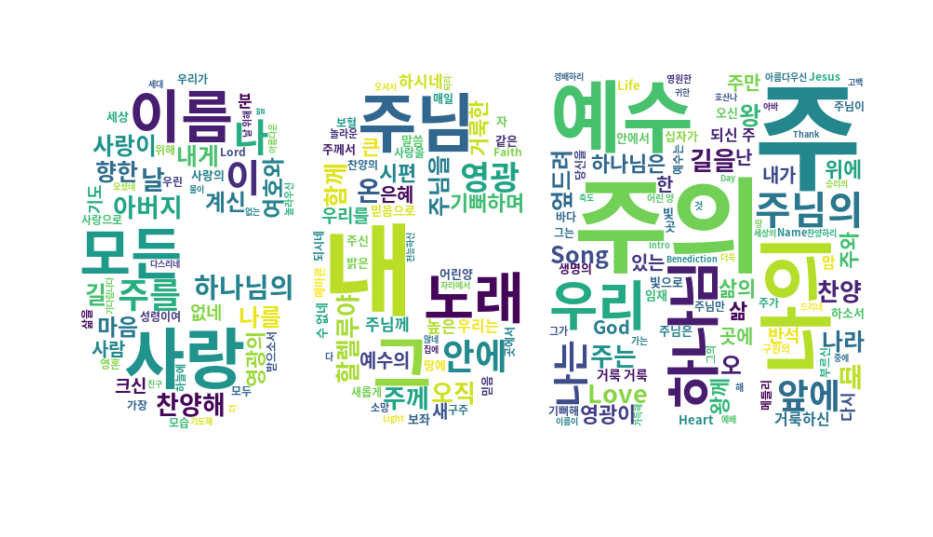

In [150]:
mask = np.array(Image.open("../image/ccm.jpeg"))
wordcloud = WordCloud(
    font_path = '/Users/hyun-young/Library/Application Support/vrew/fonts/NotoSansCJKkr-Bold.otf',
    width = 960,
    height = 540,
    background_color="white",
    mask=mask
)

wordcloud = wordcloud.generate_from_text(' '.join(all_title_refine))
array = wordcloud.to_array()
#     print(type(array)) # numpy.ndarray
#     print(array.shape) # (800, 800, 3)

fig = plt.figure(figsize=(16, 10))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()
# plt.savefig("ccm_result.png")
plt.imsave('new_1.png',array)



In [152]:
wordcloud.words_

{'주': 1.0,
 '주의': 0.7551020408163265,
 '내': 0.7040816326530612,
 '예수': 0.5306122448979592,
 '나의': 0.4897959183673469,
 '사랑': 0.3673469387755102,
 '그': 0.3469387755102041,
 '주님': 0.3469387755102041,
 '이름': 0.2653061224489796,
 '모든': 0.25510204081632654,
 '노래': 0.24489795918367346,
 '하나님': 0.23469387755102042,
 '우리': 0.22448979591836735,
 '주님의': 0.20408163265306123,
 '나': 0.19387755102040816,
 '이': 0.19387755102040816,
 '나는': 0.17346938775510204,
 '안에': 0.16326530612244897,
 '주를': 0.15306122448979592,
 '앞에': 0.15306122448979592,
 '영광': 0.1326530612244898,
 '하나님의': 0.1326530612244898,
 '온': 0.12244897959183673,
 '날': 0.12244897959183673,
 '때': 0.12244897959183673,
 '주는': 0.11224489795918367,
 '아버지': 0.11224489795918367,
 '주께': 0.11224489795918367,
 '찬양해': 0.11224489795918367,
 '길을': 0.11224489795918367,
 'Love': 0.11224489795918367,
 '찬양': 0.10204081632653061,
 '함께': 0.10204081632653061,
 '왕': 0.10204081632653061,
 '할렐루야': 0.10204081632653061,
 '오직': 0.10204081632653061,
 '내게': 0.09183673

In [406]:
[k for k,v in wordcloud.words_.items()][:10]

['주', '주의', '내', '예수', '나의', '사랑', '그', '주님', '이름', '모든']

# 요약

In [22]:
su = Pororo(task='summarization', lang='ko')

In [24]:
notna_data= data[data['lylics'].notna()]
notna_data.head()

,index,title,artist_x,album,lylics,category,artist_y,title_song,date,nb_songs,hearts
0,0.0,온 땅의 주인 (Who Am I),어노인팅,어노인팅 12집,온 땅의 주인 되신 주님이\n내 이름 아시며 상한 맘 돌보네\n어둠을 밝히시는 새벽...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
1,25.0,매일 매일,어노인팅,어노인팅 12집,매일 매일\n반복되는 갈등 속에 하루하루\n선택이란 갈림길에 치열하게\n살아가는 우...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
2,81.0,주 사랑 앞에 엎드려,어노인팅,어노인팅 12집,주 사랑 앞에 엎드려\n그 인자하심 경배해\n두렵고 친밀한 주님\n내 영혼 떨며 기...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
3,103.0,나에게도 말씀하소서,어노인팅,어노인팅 12집,낯설고 고된 삶 내 마음 들추는\n덧없는 상실 속에서\n외롭고 거친 삶 내 마음 떨...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"
4,112.0,주와 마주할 그 때,어노인팅,어노인팅 12집,영원한 시간을 빚으시고\n영원한 생명을 놓으신 주\n한낱 숨결 같은 세월을 딛고\n...,정규,어노인팅,나에게도 말씀하소서,2017-02-16,15곡,"2,526"


In [40]:
su_data = []
for i in tqdm(notna_data[['index','lylics']].values[:10]):
#     print(i)
    lylics = '.'.join(i[1].split("\n"))
    su_data.append([i[0],su(lylics),lylics])

In [42]:
[i[1] for i in su_data]

['온님이시네. 나는 오늘 피었다 지는. 이름 없는 꽃과 같고 바다에 이는 파도와 같지만.주는 나를 붙드시고.',
 '반가운 주의 음성으로 매일 매일.반복되는 갈등 속에 하루하루.선택이란 갈림길에 놓여있는 우리들의 시간 속에서  매일 같이.사랑이란 이름으로 하루 종일.동행하며 영원으로 이끄시는.진실하신 아름다움 노래하리.주의 얼굴을 구하는 이 자리.',
 '죄배합니다.사랑합니다 사랑합니다.',
 '내설고 고된 삶 내 마음 들추는.외롭고 거친 삶 내 마음 떨구는.외로운.내 영혼 메말라 갈 때.애원하는 목소리 아파하는 맘.들으소서 주여.',
 '영혼 영혼이 서로.마주할 그 때에.고뇌의 옷을 벗고 영원을 누리리. 내 영혼이.마주하는 그 때에.마주의 옷을.마주의 그 때에.',
 '기 노래로 주를 찬양하고 기쁨으로 주를 기뻐하는.',
 '마음의 노래를 들으시는 주님.두려움에서 지금 일어나사랑으로 오라 하시며.주를 예배합니다.',
 '이 호흡 주 향한 노래는 모든 열방의 기쁨과 함께 나의 삶을 드리는 것에 변하지 않는 마음인 모든 호흡 주 향한 노래를 담아냈다.',
 '주의 신을 떠나서 내가 새벽 날개 치며.저 바다 끝에 거해도.어둠도 숨기지 못하며 주님의 위대하심을 내가 고백한다.',
 '소님의 진노가 멈추고 곧 오시네 곧 오시네.']

## 유사도 분석 Document similarity

In [21]:
from pororo import Pororo


se = Pororo(task='se', lang='ko')
se

[TASK]: SE
[LANG]: KO
[MODEL]: brainsbert.base.ko.kornli.korsts

In [42]:
def remove_dupulication_lylics(lylics_list):
    out = []
    
    for s in lylics_list :
        if s not in out:
            out.append(s)
            
    return out

In [67]:
se_data = {}
se_data_not_duplication = {}
for i in tqdm(notna_data[['title','lylics']].values):
#     print(i)
    lylics = '. '.join(i[1].split("\n"))
    refine_lylics = '. '.join(remove_dupulication_lylics(i[1].split("\n")))
    se_data[i[0]] = se(lylics)
    se_data_not_duplication[i[0]] = se(refine_lylics)

/Users/hyun-young/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1337 [00:00<?, ?it/s]

In [32]:
from scipy import spatial

In [33]:
dict_res = dict()
for title in tqdm(se_data.keys()):
    temp_list = []
    vec_a = se_data[title]
    for another_title in se_data.keys():
        if another_title == title :
            continue
        vec_b = se_data[another_title]
        sim = 1 - spatial.distance.cosine(vec_a, vec_b)
        if sim > 0.1 and sim < 1.0:
            temp_list.append([another_title, sim])
    dict_res[title] = pd.DataFrame(temp_list,columns=['title','score']).sample(frac=1.0)\
                            .drop_duplicates(subset=['score']).sort_values(by='score',ascending=False)\
                            .head(20)['title'].tolist()



/Users/hyun-young/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1172 [00:00<?, ?it/s]

In [124]:
dict_res['예배합니다']

['오직 주님 한 분만이',
 '내 맘을 열어',
 '주님을 맞이하며 (Here For You)',
 'Jesus',
 '주 예배하는 삶 My Life To You (인도 : 소진영)',
 '시편 118편 (부제 : 주는 나의 하나님이시라)',
 '찬양의 이유 (Inst.)',
 '주님의 보좌 앞에서 Before The Throne Of God Above',
 '찬양의 이유',
 '내 구주 예수님',
 '내 안의 중심이 주를 찬양',
 '두 손 들고 찬양합니다',
 '언제나 주만 (MR)',
 '이 세상 끝까지',
 '크신 사랑 온 땅 찬양해',
 '찬양의 제사 드리며 (Inst.)',
 '주님이 부르신 곳',
 '이 세상을 본받지 않으며 (부제 : 주님이 부르신 곳)',
 '주님만 찬양하리',
 '나 이제 돌아가']

In [125]:
dict_res['우리 주 하나님']

['주님 큰 영광 받으소서',
 '내 안의 중심이 주를 찬양',
 '내 영혼에 빛',
 '주님의 마음을 본받는 자',
 '내가 매일 기쁘게',
 '나의 하나님은',
 '세상의 길과 다른 길 (The Incompatible Way) (인도 : 심종호)',
 '주님 보좌 앞에 나아가',
 '주님의 마음을 본받는 자 (Inst.)',
 '하늘에 가득 찬 영광의 하나님',
 '승리하리라',
 '내 영혼이 은총 입어',
 '모든 민족에게',
 '주의 집에 영광이 가득해',
 'With Me (전능하신 하나님)',
 '주님 계신 곳에 나가리',
 '주님이 부르신 곳',
 '우리는 주의 움직이는 교회',
 '이 세상을 본받지 않으며 (부제 : 주님이 부르신 곳)',
 '우리는 주의 교회']

### using tf-idf

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer() # TF-IDF 객체선언

In [43]:
lylics_data = {}
for i in tqdm(notna_data[['title','lylics']].values):
#     print(i)
    lylics_data[i[0]] = '. '.join(remove_dupulication_lylics(i[1].split("\n")))

  0%|          | 0/1337 [00:00<?, ?it/s]

In [44]:
target = list(lylics_data.values())

In [56]:
from konlpy.tag import Okt


okt = Okt()

doc_nouns_list = [' '.join(okt.nouns(doc)) for doc in target]
# print(doc_nouns_list)


### 베스트 모델

- tfidf + 중복 제거 + 명사 추출

In [59]:
matrix2 = tfidf_vectorizer.fit_transform(doc_nouns_list) # 단어를 학습시킴
tfidf_vectorizer.vocabulary_ # 단어사전을 출력

# tfidf_vectorizer.idf_.shape
doc_similarities2 = (matrix2 * matrix2.T)

In [2]:
sorted(tfidf_vectorizer.vocabulary_.items())


NameError: name 'tfidf_vectorizer' is not defined

In [60]:
tfidf_result2 = {}
for idx, doc_sim in enumerate(doc_similarities2.toarray()):
    tfidf_result2[list(lylics_data.keys())[idx]]  = sorted(list(zip(list(lylics_data.keys()), doc_sim)), key = lambda x: x[1], reverse= True)[:20]

In [61]:
title2nouns = dict(zip(list(lylics_data.keys()),doc_nouns_list))

In [51]:
tfidf_result2['시선']

[('시선', 0.9999999999999999),
 ('주님의 마음 있는 곳', 0.4378918215795345),
 ('찬양의 이유', 0.32257294093078104),
 ('Fire', 0.31701680606679894),
 ('놀라운 주 (Wonderful God)', 0.3119413894993927),
 ('주님 나라 임하시네', 0.3115233999055927),
 ('You Are God', 0.3089455492865161),
 ('기뻐하라', 0.3078290044435147),
 ('해가 뜨는 데부터', 0.2988455886455534),
 ('주 예수의 날에', 0.2918655063159841),
 ('광대하신 주님', 0.28856096724092106),
 ('새로운 마음', 0.28521672937742665),
 ('모든 열방 주 볼 때까지', 0.2751600803849819),
 ('소리 높여 (MR)', 0.27405531402143846),
 ('주의 말씀 앞에 선', 0.2729465871724954),
 ('주님의 영광', 0.26947621031668156),
 ('사랑하는 나의 아버지', 0.26649789601543217),
 ('하나님 말씀으로', 0.264364389613325),
 ('그곳에서 시작되네 Where It Begins', 0.2619071606394783),
 ('주님께 감사 드리라', 0.26081044266104436)]

In [38]:
tfidf_result2['성령이 오셨네']

[('성령이 오셨네', 1.0000000000000002),
 ('성령 하나님', 0.47317984992526363),
 ('오소서', 0.4424735185955251),
 ('내 맘속에 거하시는 (Joy In The Holy Ghost)', 0.4376015909359222),
 ('성령의 바람 (Wind Of God)', 0.43551403896848684),
 ('메마른 우리마음', 0.4165050893816822),
 ('With One Heart', 0.3460008461071033),
 ('성령의 불로', 0.33652253295879464),
 ('주님의 영광 나타나셨네 (The Lord Has Displayed His Glory)', 0.3303593517489906),
 ('나를 가르치소서', 0.3221695283096232),
 ('기뻐할 수 있음은 Rejoicing In You (인도 : 심종호)', 0.31965538010891675),
 ('부어주소서 주님의 성령', 0.3185307280715916),
 ('영원한 사귐으로', 0.31503890853817484),
 ('성령의 비가 내리네', 0.3143068842361782),
 ('성령이여 ＆ 성령이여 내 영혼에', 0.3103827457360059),
 ('거룩 거룩 거룩 + 3 In One', 0.3098693861546156),
 ('눈을 들어', 0.30792530994105904),
 ('주는 나의 빛되사', 0.30375826988060395),
 ('하늘의 나는 새도 (강명식)', 0.3037488020400466),
 ('온 세계 위에', 0.3032907003018428)]

In [52]:
tfidf_result2['하나님의 사랑이']

[('하나님의 사랑이', 1.0000000000000002),
 ('사랑의 열매 (Inst.)', 0.6277552043637581),
 ('사랑의 열매 (마커스 축복송)', 0.5189830840666555),
 ('당신을 향한 노래', 0.3937647229760014),
 ('허망해 보이나', 0.3815542348039933),
 ('우리 모일 때 주 성령 임하리', 0.37762529185279964),
 ('사랑 중에 사랑 (Feat. Sein) (Prod. Jamieh)', 0.36375883223410166),
 ('축복하소서', 0.3570574425011697),
 ('여호와 주님', 0.31695254414525165),
 ('고된 하루를 보내고', 0.31504595559033205),
 ('당신은 하나님의 거룩한 성전', 0.3134174583804665),
 ('시간을 뚫고 (Prod. Jamieh)', 0.3001065017754215),
 ('길을 만드시는 분 (Way Maker) (인도 : 소진영)', 0.2991971514938816),
 ('축복의 통로', 0.2978852648219983),
 ('우리 주이름으로 모였으니', 0.29773059391260576),
 ('세상 가운데 소망을', 0.2974110595870739),
 ('시간을 뚫고', 0.2943902375403329),
 ('주의 집에 거하는 자 (Blessed) (인도 : 심종호)', 0.2889707196374097),
 ('주만 바라볼지라', 0.28800463095986345),
 ('빛 되신 주', 0.2876667884885913)]

In [65]:
tfidf_result2['유월절의 어린양의 피로']

[('유월절의 어린양의 피로', 1.0),
 ('예수 피 밖에', 0.46738822155280685),
 ('흐르네 주 보혈', 0.4490149476979082),
 ('죄에서 자유를 얻게 함은', 0.43645251419722364),
 ('주의 보혈 능력있도다', 0.43538922511506245),
 ('승리를 주신 주님께', 0.41857042720778137),
 ('보혈을 지나', 0.3853981707646668),
 ('예수 피를 힘입어 (오재성)', 0.2520651909457477),
 ('예수 피를 힘입어', 0.24164242478627448),
 ('구원의 강', 0.22550100794494993),
 ('주 없이 살 수 없네', 0.22461591349703158),
 ('하나님 우리를 사랑하사', 0.21817676141917036),
 ('주님의 임재 앞에서', 0.21644049321353528),
 ('피난처', 0.21518497035518067),
 ('주님의 임재 앞에서 (Bonus Track)', 0.20219528908127654),
 ('큰 죄에 빠진 날 위해 - 나 주의 도움 받고자', 0.19437227382042221),
 ('엎드려 경배해 (Mercy)', 0.1787005039250095),
 ('하나님의 그늘 아래', 0.16330073241326448),
 ('은혜 아래 있네', 0.16175446091663648),
 ('하늘보좌', 0.16135484112263188)]